In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# General data processing and math
import numpy as np
import pandas as pd
import os
import math
import random
from PIL import Image
import gdown
import sys
import copy
import zipfile

sys.path.append('/content/drive/MyDrive/SimpleGAN')

# Visialization
import matplotlib.pyplot as plt

# Deep Learning
import torch
from torch import nn, autograd, optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
torch.backends.cudnn.benchmark = True # Good for inputs of the same size

# Warning elimination
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline

In [3]:
drive_ids = {
    "stylegan2-ffhq-config-f.pt": "1Yr7KuD959btpmcKGAUsbAk5rPjX2MytK",
}

def download_file(file_name, dst):
    f_dst = os.path.join('/content/drive/MyDrive/SimpleGAN', dst)
    f_id = drive_ids[file_name]
    gdown.download(f"https://drive.google.com/uc?id={f_id}", f_dst + '/' + file_name)

def unzip_file(file_path, dst):
  f_dst = os.path.join('/content/drive/MyDrive/SimpleGAN', dst)
  with zipfile.ZipFile(file_path, 'r') as zip_ref:
      zip_ref.extractall(f_dst)

In [4]:
# zip_file_path = '/content/drive/MyDrive/SimpleGAN/input/img_align_celeba.zip'
# dst = 'input'
# unzip_file(zip_file_path, dst)

In [5]:
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [6]:
# Initializing seeds of RNGs

S = 999
# S = random.randint(1, 10000)
random.seed(S)
torch.manual_seed(S)
torch.use_deterministic_algorithms(True)

In [7]:
# Hyperparams

batch_size = 128
num_epochs = 5
lr = 0.0002
beta1 = 0.5

# Image params

image_size = 64 # Size of training images, otherwise they will be resized by a transformer.
nc = 3 # Number of channels
nz = 100 # Size of z latent vector (i.e. size of generator input)
ngf = 64 # Size of feature maps in generator
ndf = 64 # Size of feature maps in discriminator

workers = 2 # Number of workers for dataloader


In [8]:
# Load data
dataset = datasets.ImageFolder(root='/content/drive/MyDrive/SimpleGAN/input',
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

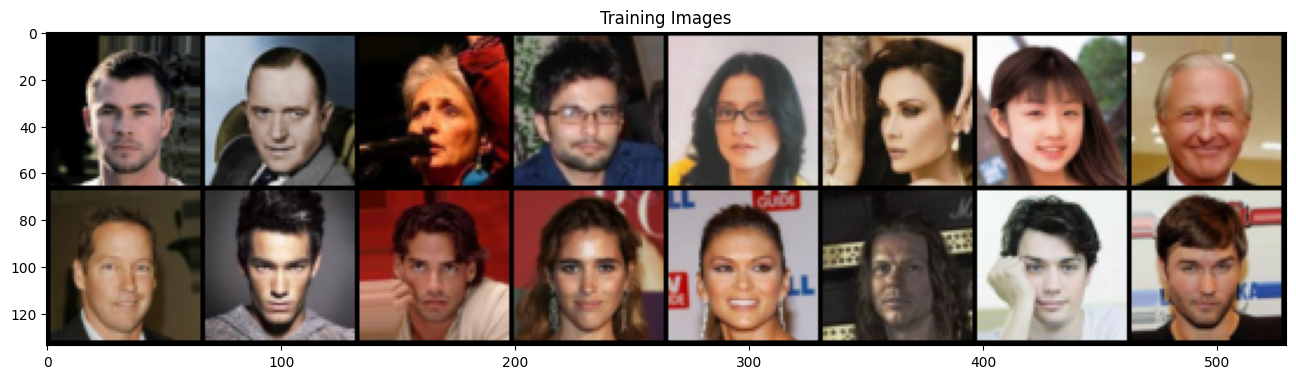

In [9]:
# Plot some training images

samples = next(iter(dataloader))


plt.figure(figsize=(16,16))
plt.title("Training Images")
plt.imshow(utils.make_grid(samples[0].to(device)[:16], padding=2, normalize=True).cpu().permute(1,2,0))

In [10]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [11]:
# Create the generator
netG = Generator(ngpu).to(device)
netD = Discriminator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

netG.apply(weights_init)
netD.apply(weights_init)

criterion = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [12]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

real_label = 1.
fake_label = 0.

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        netD.zero_grad()
        real_cpu = data[0].to(device)
        output = netD(real_cpu).view(-1)
        b_size = output.shape[0]
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()


        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step() # Update D

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())


        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/296]	Loss_D: 1.6567	Loss_G: 5.3252	D(x): 0.5512	D(G(z)): 0.5501 / 0.0080
[0/5][50/296]	Loss_D: 0.2882	Loss_G: 9.9885	D(x): 0.8988	D(G(z)): 0.0124 / 0.0001
[0/5][100/296]	Loss_D: 1.9017	Loss_G: 17.4707	D(x): 0.9752	D(G(z)): 0.7165 / 0.0000
[0/5][150/296]	Loss_D: 0.5286	Loss_G: 3.2938	D(x): 0.7812	D(G(z)): 0.1279 / 0.0557
[0/5][200/296]	Loss_D: 0.7593	Loss_G: 3.4252	D(x): 0.6571	D(G(z)): 0.0509 / 0.0628
[0/5][250/296]	Loss_D: 0.6989	Loss_G: 3.7461	D(x): 0.7093	D(G(z)): 0.0756 / 0.0876
[1/5][0/296]	Loss_D: 0.6247	Loss_G: 3.0711	D(x): 0.6963	D(G(z)): 0.1102 / 0.0775
[1/5][50/296]	Loss_D: 0.5442	Loss_G: 3.0542	D(x): 0.7624	D(G(z)): 0.1429 / 0.0782
[1/5][100/296]	Loss_D: 0.3696	Loss_G: 3.6735	D(x): 0.8580	D(G(z)): 0.1406 / 0.0433
[1/5][150/296]	Loss_D: 0.5684	Loss_G: 3.4284	D(x): 0.7001	D(G(z)): 0.0659 / 0.0530
[1/5][200/296]	Loss_D: 0.4751	Loss_G: 5.5783	D(x): 0.9359	D(G(z)): 0.2541 / 0.0141
[1/5][250/296]	Loss_D: 0.7037	Loss_G: 7.1329	D(x): 0.8833	D(G(z)):

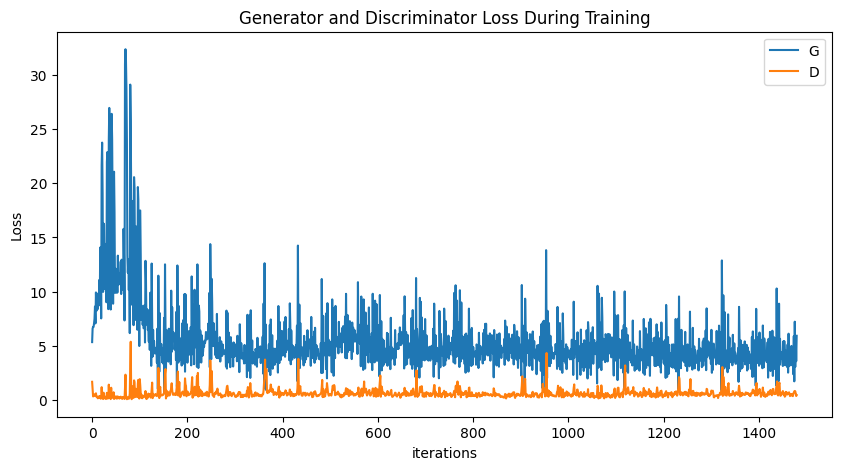

In [13]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

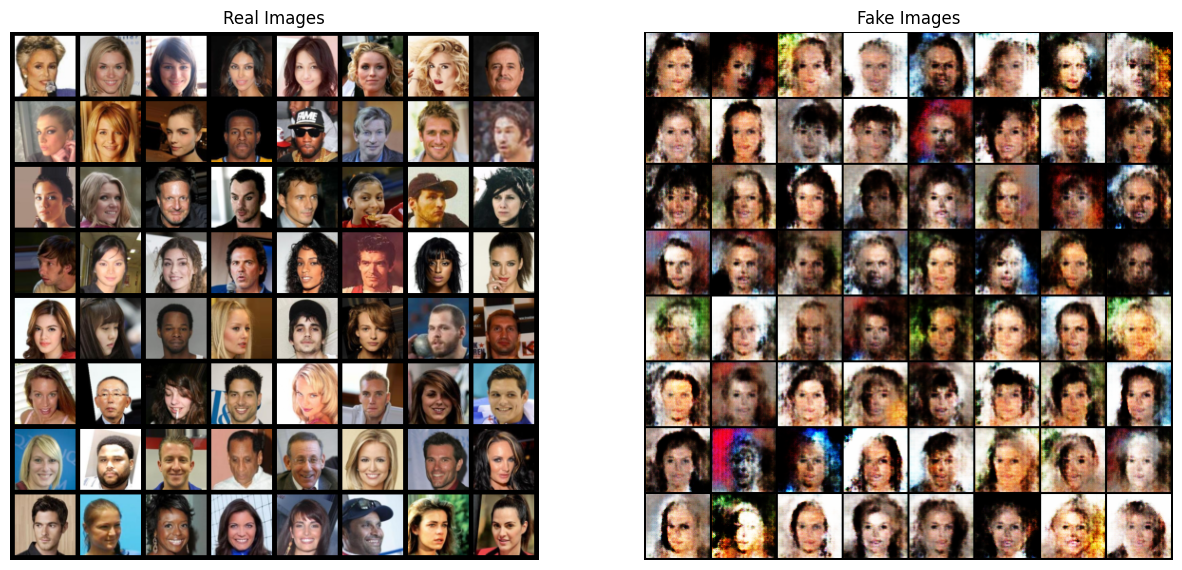

In [14]:
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

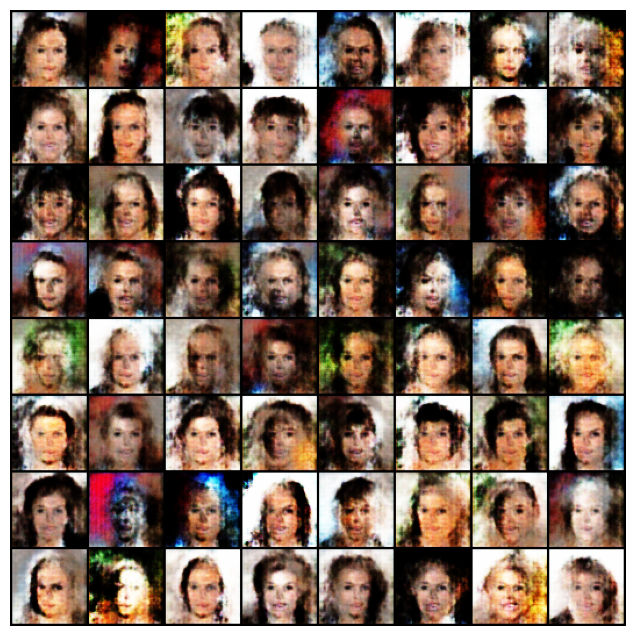

In [15]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())